Dataset Shape: (72139, 2)
    sentiment                                            comment
0    Positive  This looks like a poster for a 90s action movi...
1  Irrelevant  How Abhijeet Bhayya ur efforts are incredible ...
2     Neutral  Transvaginal mesh: Johnson & Johnson fined $34...
3    Negative  Why would this fortnite college hockey season ...
4    Positive  I actually quite like the design of the ps5. I...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 14428/14428 [00:02<00:00, 6658.10 examples/s]
C:\Users\USERAS\AppData\Local\Temp\ipykernel_28008\1243449088.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.518500,0.491083,0.823815,0.822492
2,0.330700,0.370487,0.900956,0.900908
3,0.304300,0.378333,0.917383,0.917414


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Evaluation results: {'eval_loss': 0.3704874813556671, 'eval_accuracy': 0.9009564735237039, 'eval_f1': 0.9009080910685231, 'eval_runtime': 85.0318, 'eval_samples_per_second': 169.678, 'eval_steps_per_second': 21.216, 'epoch': 3.0}


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.91      0.87      0.89      2514
    Negative       0.91      0.92      0.92      4372
     Neutral       0.90      0.89      0.90      3528
    Positive       0.88      0.91      0.89      4014

    accuracy                           0.90     14428
   macro avg       0.90      0.90      0.90     14428
weighted avg       0.90      0.90      0.90     14428



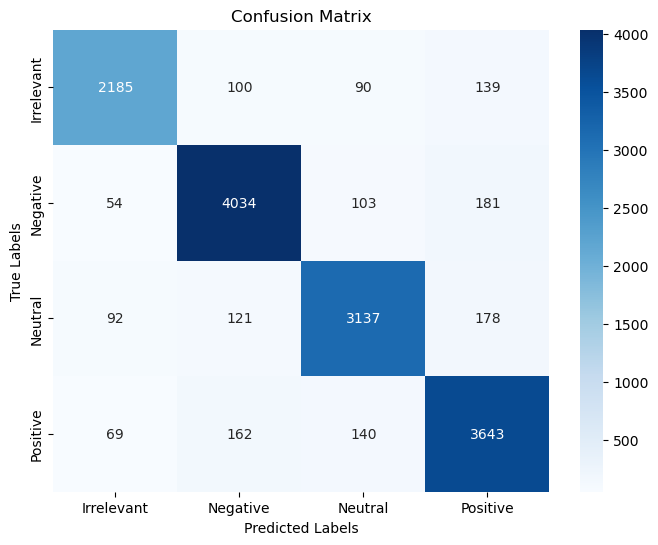

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("twitter-sentiment/sentiment-dataset.csv")
print("Dataset Shape:", df.shape)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.head())

# Check for missing values
df.dropna(inplace=True)

# Extract features and labels
X = df['comment']
y = df['sentiment']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to Hugging Face dataset
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data = data.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'bert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text']).rename_column('label', 'labels')
data.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate predictions
predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [3]:
torch.cuda.empty_cache()

Dataset Shape: (72139, 2)
    sentiment                                            comment
0    Positive  This looks like a poster for a 90s action movi...
1  Irrelevant  How Abhijeet Bhayya ur efforts are incredible ...
2     Neutral  Transvaginal mesh: Johnson & Johnson fined $34...
3    Negative  Why would this fortnite college hockey season ...
4    Positive  I actually quite like the design of the ps5. I...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 14428/14428 [00:01<00:00, 8845.94 examples/s]
C:\Users\USERAS\AppData\Local\Temp\ipykernel_28008\554082266.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.834000,0.667678,0.748129,0.745933
2,0.517700,0.501483,0.846618,0.846659
3,0.399900,0.521213,0.873371,0.873122


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Evaluation results: {'eval_loss': 0.5014828443527222, 'eval_accuracy': 0.846617687829221, 'eval_f1': 0.8466585189898447, 'eval_runtime': 80.9852, 'eval_samples_per_second': 178.156, 'eval_steps_per_second': 22.276, 'epoch': 3.0}


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.86      0.77      0.81      2514
    Negative       0.89      0.87      0.88      4372
     Neutral       0.79      0.84      0.82      3528
    Positive       0.84      0.87      0.85      4014

    accuracy                           0.85     14428
   macro avg       0.85      0.84      0.84     14428
weighted avg       0.85      0.85      0.85     14428



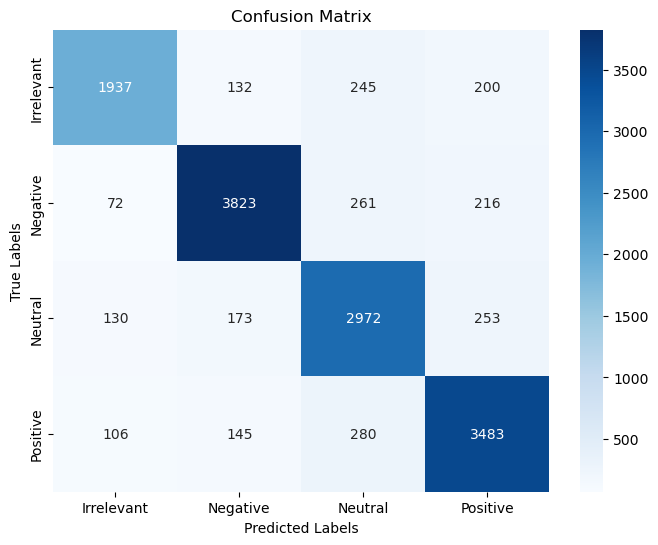

In [4]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("twitter-sentiment/sentiment-dataset.csv")
print("Dataset Shape:", df.shape)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.head())

# Check for missing values
df.dropna(inplace=True)

# Extract features and labels
X = df['comment']
y = df['sentiment']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to Hugging Face dataset
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data = data.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'xlm-roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text']).rename_column('label', 'labels')
data.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate predictions
predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


--- Logistic Regression ---
Accuracy: 0.8195
F1 Score: 0.8192
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.85      0.76      0.80      2525
    Negative       0.82      0.86      0.84      4358
     Neutral       0.86      0.77      0.82      3576
    Positive       0.78      0.86      0.81      3969

    accuracy                           0.82     14428
   macro avg       0.83      0.81      0.82     14428
weighted avg       0.82      0.82      0.82     14428



c:\Users\souvi\anaconda3\envs\resPy\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


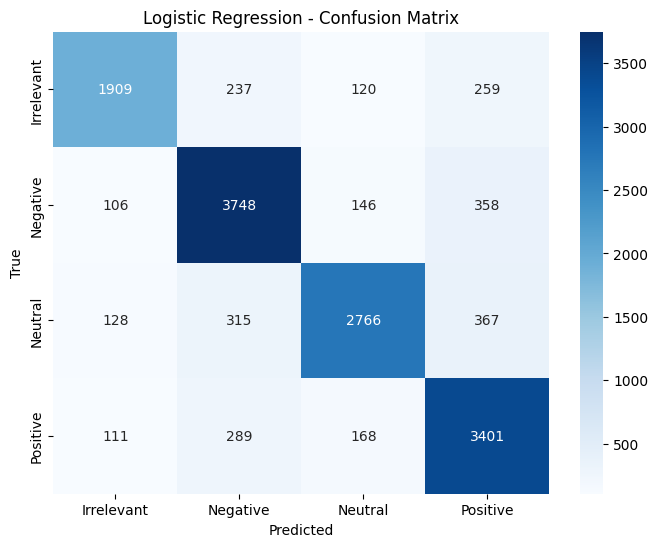


--- K-Nearest Neighbors ---
Accuracy: 0.8716
F1 Score: 0.8715
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.87      0.86      0.86      2525
    Negative       0.86      0.90      0.88      4358
     Neutral       0.88      0.86      0.87      3576
    Positive       0.88      0.85      0.87      3969

    accuracy                           0.87     14428
   macro avg       0.87      0.87      0.87     14428
weighted avg       0.87      0.87      0.87     14428



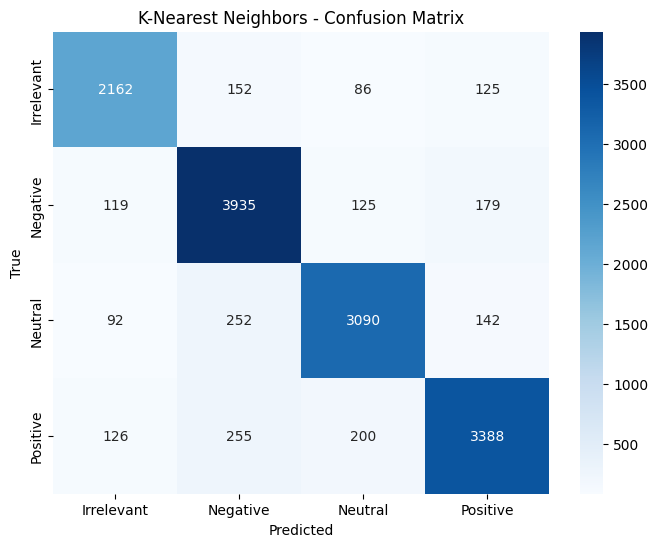


--- Naive Bayes ---
Accuracy: 0.7476
F1 Score: 0.7451
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.82      0.64      0.72      2525
    Negative       0.70      0.86      0.77      4358
     Neutral       0.83      0.63      0.72      3576
    Positive       0.72      0.81      0.76      3969

    accuracy                           0.75     14428
   macro avg       0.77      0.73      0.74     14428
weighted avg       0.76      0.75      0.75     14428



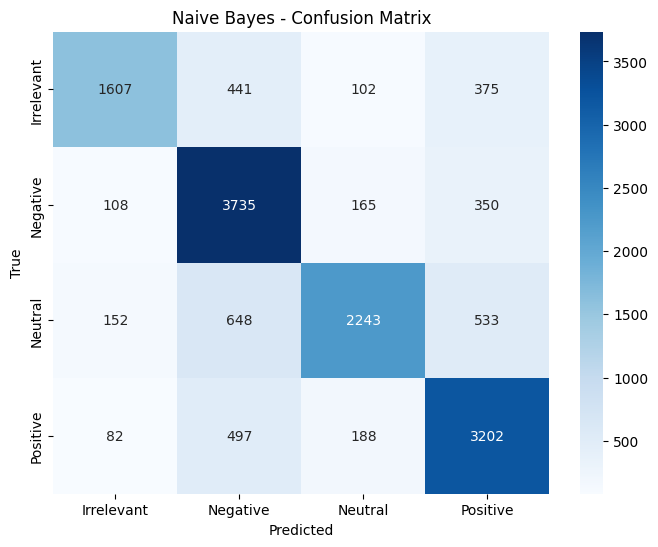


--- Decision Tree ---
Accuracy: 0.7844
F1 Score: 0.7842
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.77      0.72      0.74      2525
    Negative       0.80      0.81      0.81      4358
     Neutral       0.78      0.80      0.78      3576
    Positive       0.78      0.78      0.78      3969

    accuracy                           0.78     14428
   macro avg       0.78      0.78      0.78     14428
weighted avg       0.78      0.78      0.78     14428



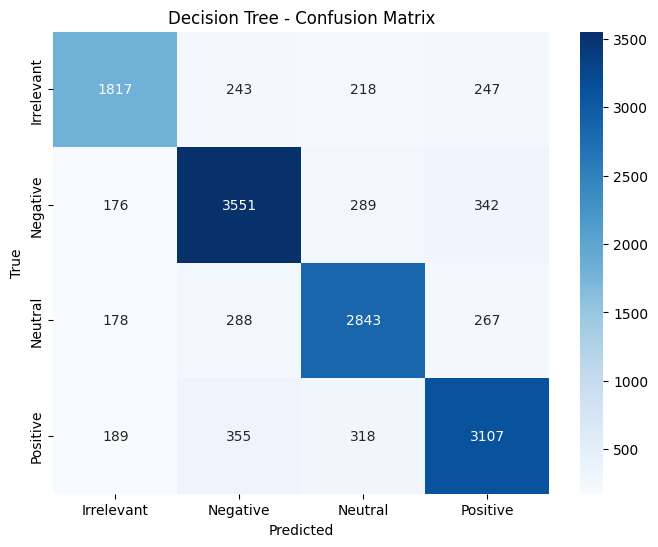


--- Gradient Boost ---
Accuracy: 0.5349
F1 Score: 0.5112
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.66      0.18      0.28      2525
    Negative       0.48      0.80      0.60      4358
     Neutral       0.61      0.42      0.50      3576
    Positive       0.57      0.57      0.57      3969

    accuracy                           0.53     14428
   macro avg       0.58      0.49      0.49     14428
weighted avg       0.57      0.53      0.51     14428



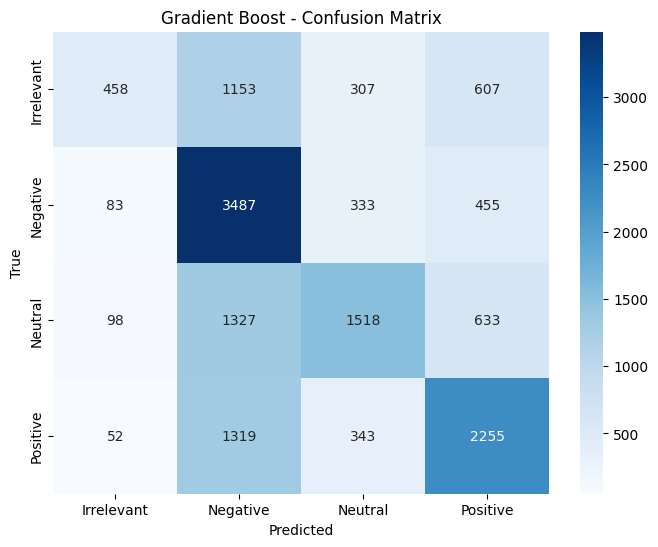

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Load datasets
df = pd.read_csv("twitter-sentiment/sentiment-dataset.csv")
df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

# Check for missing values and shuffle
def preprocess_df(df):
    df.dropna(inplace=True)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

df = preprocess_df(df)

X = df["comment"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
label_list = label_encoder.classes_

# Vectorization
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boost": GradientBoostingClassifier()
}

# Train and Evaluate
for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    model.fit(X_train_vec, y_train_encoded)
    y_pred = model.predict(X_test_vec)
    
    acc = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(y_test_encoded, y_pred, target_names=label_list))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()